# Salary Analysis & Predictions Based on Job Descriptions

## Using 4D framework
***

# Objectives

- To understand how salary is influenced by years of experience, location away from city, major, industry, and type of position to understand how: 

    - Candidates can strategically target the company they want to work for to achieve their desired salary.
    
    - Companies can allocate budget for new hires based on these factors and adjust qualifications accordingly.
    

- To create a model that predicts the salary of a new hire based on job descriptions. 

The implementation of this model will allow management to allocate budget for new hires to avoid underpaying or overpaying them.

***

# Table of Contents

### Part 1 - DEFINE
#### 1. Define the problem
- Why is over spending on new hires a problem?

### Part 2 - DISCOVER
#### 2. Load the data
#### 3. Clean the data
- Inspection of data: Missing values, data types, duplicates, summary statistics

#### 4. Explore the data (EDA)
- Correlation of numeric features
- Distribution of numeric feature
- Plots of numeric features against salary
- Boxplots of categorical features and salary
- Heatmaps of categorical features in relation to salary

#### 5. Establish a baseline
- Calculating MSE using average salary for each job type as the predicted value

#### 6. Hypothesize solutions
- How EDA informs model and feature engineering

### Part 3 - DEVELOP
#### 7. Engineer features
- One-hot encoding of categorical features
- Splitting data into training and testing sets

#### 8. Create & test models
- Linear Regression
- Random Forest
- Gradient Boosting

#### 9. Select best model
- Based on lowest MSE

### Part 4 - DEPLOY
#### 10. Automate pipeline
- Engineer features, train, and test model on unknown data

#### 11. Deploy solution
- Saving predictions as csv and reaching out to finance team

### Part 5 - Actionable recommendations
- Budget allocation based on company and job requirements
***

# Part 1 - DEFINE

<a id='problem'></a>
### 1. Define the problem

Companies often face a problem of **over spending** on new hires, whereby they spend more money than they have to hire new people. Over spending would negatively impact the financial health of the company and result in decreased profit, debts, and even bankcruptcy if uncontrolled. 

Imagine that a company spends **500,000 dollars** on new hires annually when it has **200,000 dollars**. The company incurs a deficit of **300,000 dollars**. The company can avoid over spending by knowing how much new hires are going to cost, and compare the cost with what they have, to determine who and how many people they can hire.



#### An example

For example, a company wants to hire 2 Software Engineers and a Director of Data Science. An entry-level Software Engineer will cost about 125,000 dollars and a Director of Data Science with 10+ years of experience will cost about 250,000 dollars. The company will need to allocate **500,000 dollars.** 

If the company only has **200,000 dollars**, then it could only afford to hire an entry-level Software Engineer or an Associate Director of Data Science that is within budget. 

In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
%matplotlib inline

__author__ = "Janice Tjeng"
__email__ = "janicetjeng@gmail.com"

***
## Part 2 - DISCOVER

### 2. Load the data

In [2]:
# Importing the data
salary_features = pd.read_csv("./data/train_features.csv")
salary = pd.read_csv("./data/train_salaries.csv")

In [3]:
salary_features.shape

(1000000, 8)

In [4]:
salary.shape

(1000000, 2)

The number of rows in the features and target data sets match, so they will be combined for further sanity checks and analysis

In [5]:
# Combine both data sets
salary_combined = salary_features.join(salary.set_index("jobId"),how="inner",on="jobId")

<a id='datacleaning'></a>
### 3. Clean the data

In [6]:
# Look for missing values
salary_combined.isnull().any()

jobId                  False
companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
salary                 False
dtype: bool

In [7]:
# Check that type of features are consistent with they should be
salary_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [8]:
# Look for duplicate values
print("Number of duplicated records in training set: ", salary_combined.duplicated().sum())

Number of duplicated records in training set:  0


In [9]:
# Summarizing data with descriptive statistics to look for invalid data
salary_combined.describe()

,yearsExperience,milesFromMetropolis,salary
count,1000000.000000,1000000.000000,1000000.000000
mean,11.992386,49.529260,116.061818
std,7.212391,28.877733,38.717936
min,0.000000,0.000000,0.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


Features do not appear to be highly skewed as mean and median (50th percentile) are similar. However, we will need to investigate jobs with minimum salary of 0.

In [10]:
# Checking for rows with salary of 0
salary_combined[salary_combined.salary==0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


Executive positions and doctoral degree should not have a salary of 0. It is possible that there are errors in data collection, and removing these data points would not bias our results as they constitute a small amount of observations (5 out of 1,000,000).

In [11]:
# Removing rows with salary of 0
salary_new = salary_combined[salary_combined.salary>0]

In [12]:
# Verify that data points have been removed and there should be 5 rows less than the original
salary_new.shape[0] == salary_combined.shape[0]-5

True


### 4. Explore the data (EDA)

<a id='correlation_matrix'></a>
#### Correlation matrix

In [14]:
# Function for correlation plot
def corr_mat(data):
    corr = data.corr()
    sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
    plt.title('Heatmap of Correlation Matrix')
    return (corr)

,yearsExperience,milesFromMetropolis,salary
yearsExperience,1.000000,0.000672,0.375013
milesFromMetropolis,0.000672,1.000000,-0.297686
salary,0.375013,-0.297686,1.000000


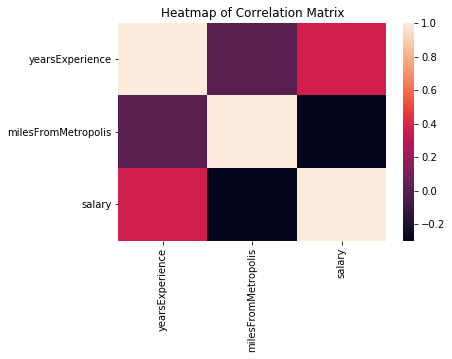

In [15]:
corr_mat(salary_new)

Salary is negatively correlated with miles from metropolis, the further the jobs are away from the city, the lower the salaries. 

Salary is positively correlated with years of experience, as jobs require people with more experience, salaries increase. 

There is a weak correlation between years of experience and miles from metropolis, the number of years of experience a job requires is not determined by where its located. 

<a id='distplots'></a>
#### Distribution plots

In [16]:
# Function to visualize distribution of numerical features
def plot_num(data,size):
    num_vars = data.select_dtypes(exclude=["object"]).columns
    plt.figure(figsize=size)
    for i in range(len(num_vars)):
        plt.subplot(3,3,i+1)
        sns.distplot(salary_new[num_vars[i]])

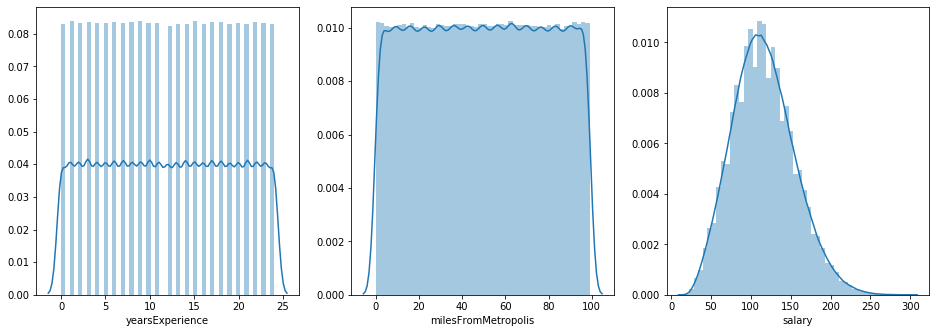

In [17]:
plot_num(salary_new,(16,18))

Salary follows a close to normal distribution, implying that a most of the jobs pay close to the average salary, with equally few jobs that are extremely low and high paying. On the other hand, years of experience and miles from metropolis have a uniform distribution, implying that there is an equal number of jobs with varying years of experience and miles away from city.

<a id='numplots'></a>

#### Plots of numeric features against target

*Years of experience and salary*

In [18]:
# Function for line plot with range between mean and std shown
def line_plot(dat,ind,dep):
    mean = salary_new.groupby(ind)[dep].mean()
    std = salary_new.groupby(ind)[dep].std()
    mean.plot()
    plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, alpha = 0.1)

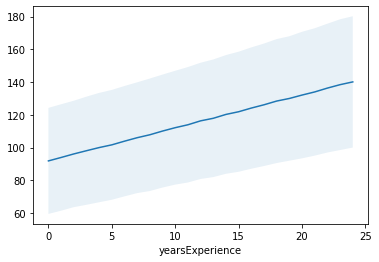

In [19]:
line_plot(salary_new,"yearsExperience","salary")

We can see that salary increases with more years of experience.

*Miles from metropolis and salary*

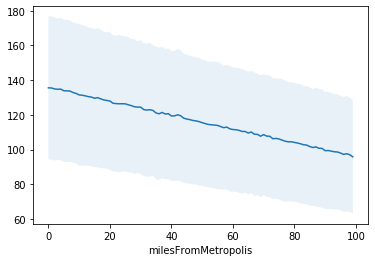

In [20]:
line_plot(salary_new,"milesFromMetropolis","salary")

We can see that salary decreases with increasing miles away from city.

<a id='boxplots'></a>
**Box plots**

We will create boxplots to visualize categorical features: jobtypes, industry, major, and degree, in relationship with salary


In [21]:
def box_plot(size,categorical_var,dep,dat):
    plt.figure(figsize=size)
    plt.suptitle("Green triangle represents mean",fontsize=16)
    for i in range(len(categorical_var)):
        mean = dat.groupby(categorical_var[i])[dep].mean()
        ordr = mean.sort_values().index.tolist()
        dat[categorical_var[i]] = dat[categorical_var[i]].astype("category")
        dat[categorical_var[i]].cat.reorder_categories(ordr, inplace=True)
        plt.subplot(2,2,i+1)
        sns.boxplot(x=categorical_var[i],y=dep, data=dat, showmeans=True)
        plt.xticks(rotation=45)
    

C:\Users\HR\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\HR\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\HR\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

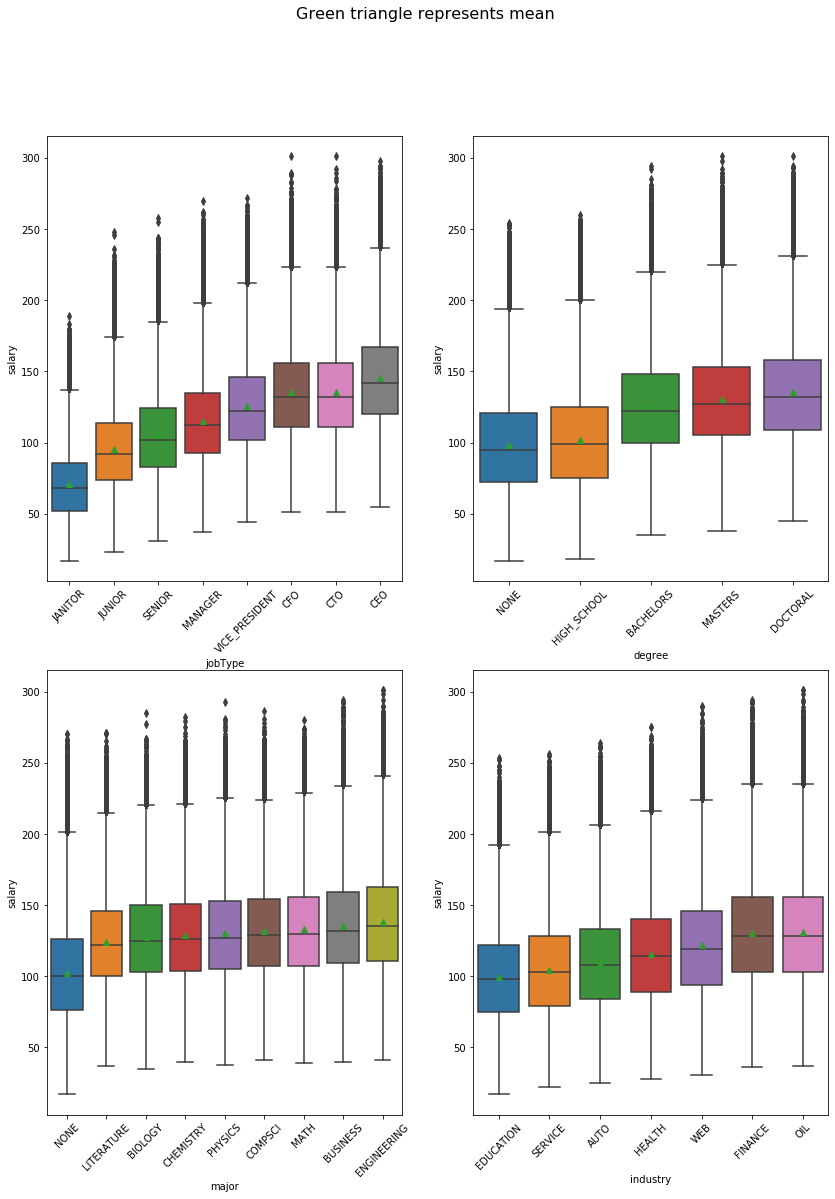

In [22]:
box_plot((14,18),["jobType","degree","major","industry"],"salary",salary_new)

*Job type and average salary*

Executive positions (CFO, CTO, CEO) have the highest average salaries while janitor has the lowest average salary. Senior and manager positions do not have huge difference in average salaries.

*Degree and average salary*

There is not much difference in average salaries between jobs that do not require a degree and those that require a high school degree. Jobs with bachelor's degree requirements have slightly lower average salaries than those with master's and doctoral degree requirements, while the latter have similar average salaries.

*Major and average salary*

Average salaries of different majors are roughly similar, except for jobs that do not require a major that have lower average salaries, which could mean that candidates for these jobs have at most a high school degree.

*Industry and salary*

Finance and oil are the highest paying industries.

<a id='bar'></a>
**Heatmaps**

We will visualize heatmaps that look at the salaries of different categorical variables.

In [23]:
def heat_map(size,ind,dat,tup,color):
    plt.figure(figsize=size)
    for i in range(len(tup)):
        plt.subplot(3,2,i+1)
        sns.heatmap(salary_new.groupby([tup[i][0],tup[i][1]])[ind].mean().reset_index().pivot(index=tup[i][1],columns=tup[i][0],values=ind),cmap=color)
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)


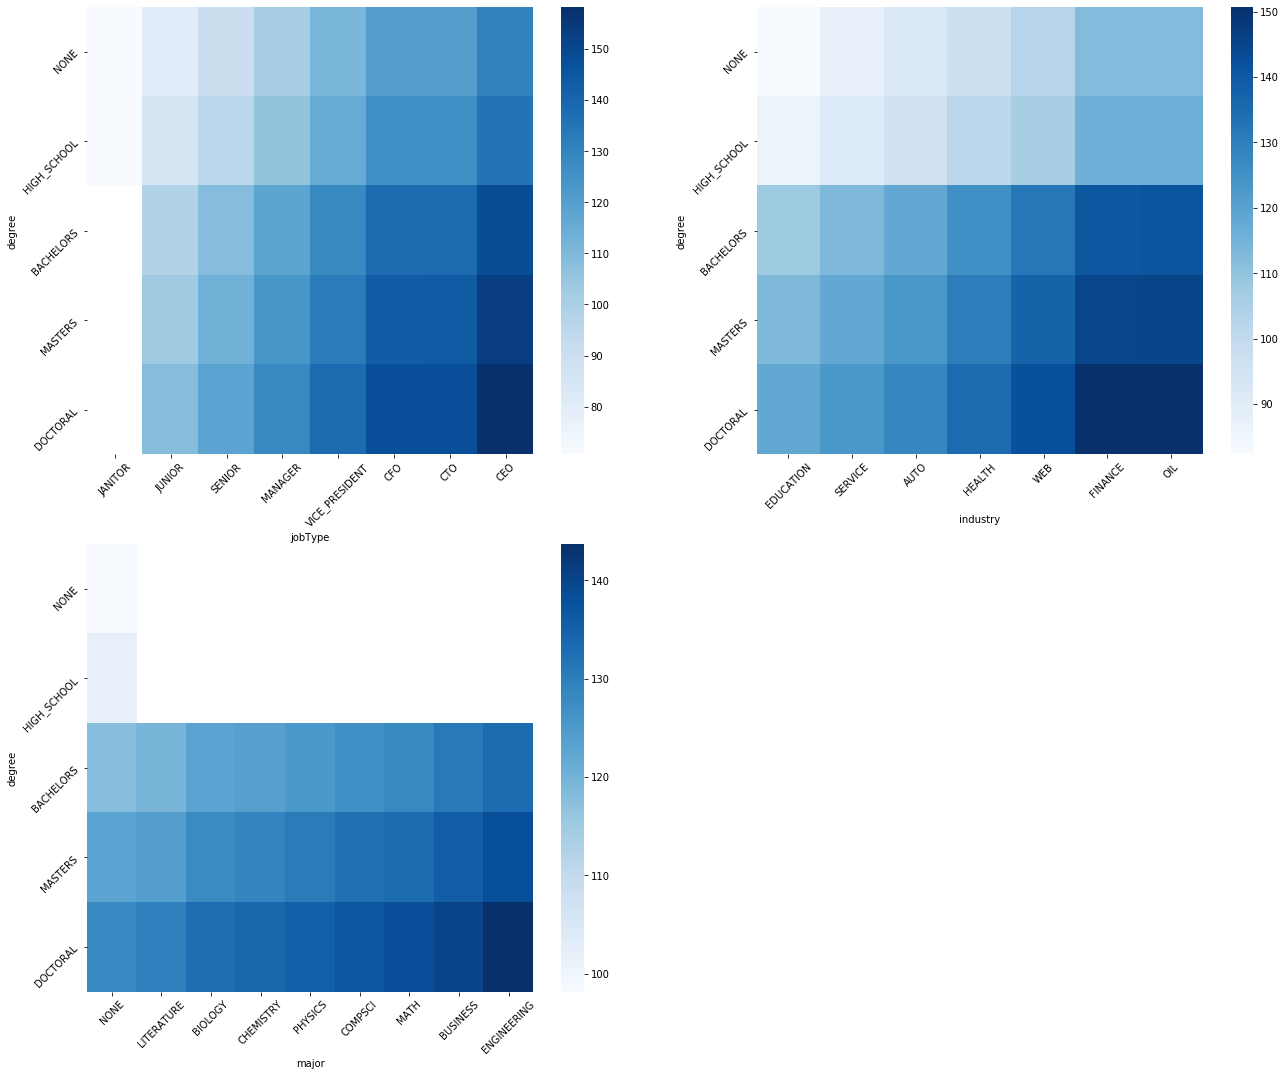

In [24]:
tup_deg = [("jobType","degree"),("industry","degree"),("major","degree")]
heat_map((22,28),"salary",salary_new,tup_deg,"Blues")

*Degree and job type*

Apart from janitorial positions that do not require more than a high school degree, all other positions have at least a bachelor's degree and consist of various degrees. It is interesting to note that more advanced degree do not necessarily pay higher for the same type of position. The career advancement (moving up to a higher position) heavily influences salary.

*Degree and industry*

It is interesting to see that more advanced degree do not pay much higher in the same industry. It is the type of industry that heavily influences salary.

*Degree and major*

We see a variety of majors across degrees and doctoral degree with engineering major is the highest paying. It is intuitive that employees with high school or without a degree would not have a major but employees with bachelor's, master's, and doctoral degrees should not have a "NONE" as their major. It is possible that their majors are not within the majors listed above. Let's inspect the data to determine what is going on. 

In [25]:
salary_combined[(salary_combined.major=="NONE") & (salary_combined.degree!="NONE") & (salary_combined.degree!="HIGH_SCHOOL")]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
24,JOB1362684407711,COMP20,CEO,BACHELORS,NONE,WEB,12,8,202
32,JOB1362684407719,COMP1,CEO,MASTERS,NONE,OIL,7,91,165
34,JOB1362684407721,COMP31,MANAGER,DOCTORAL,NONE,HEALTH,15,14,164
40,JOB1362684407727,COMP7,VICE_PRESIDENT,MASTERS,NONE,HEALTH,8,54,141
46,JOB1362684407733,COMP53,MANAGER,DOCTORAL,NONE,AUTO,19,22,116
...,...,...,...,...,...,...,...,...,...
999958,JOB1362685407645,COMP46,JUNIOR,BACHELORS,NONE,SERVICE,24,64,79
999969,JOB1362685407656,COMP37,JUNIOR,DOCTORAL,NONE,EDUCATION,21,31,131
999987,JOB1362685407674,COMP51,CFO,MASTERS,NONE,FINANCE,1,99,124
999998,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149


6% of employees with at least a bachelor's degree do not have a major and they cover a variety of job types. It is highly possible that these employees do not have majors listed in the list of majors the job portal provides. Hence, we will keep the data as such.

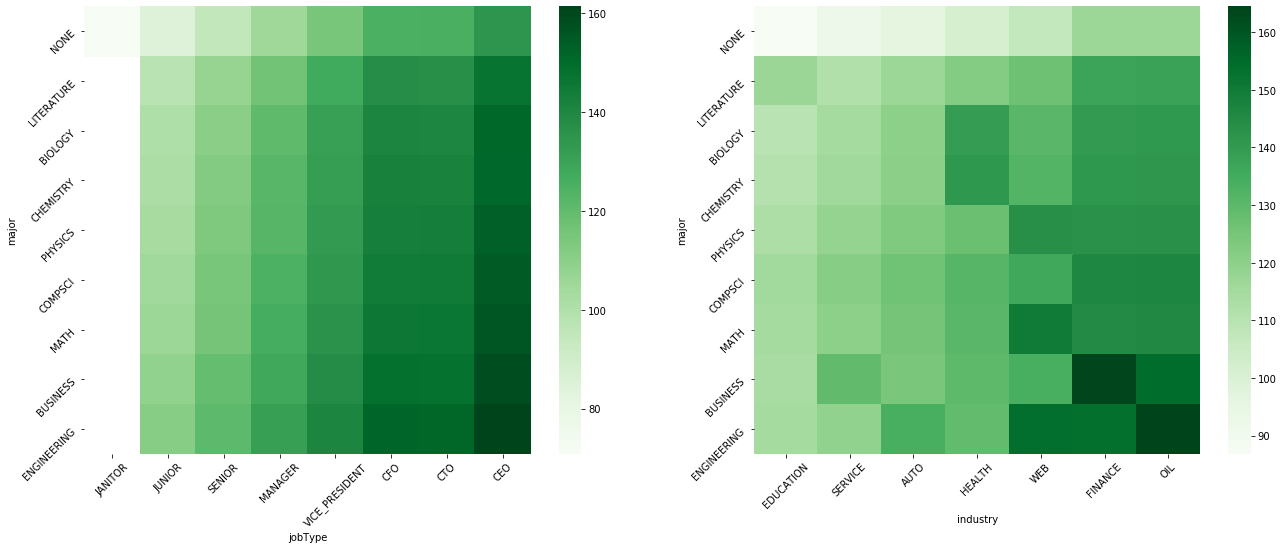

In [26]:
tup_major = [("jobType","major"),("industry","major")]
heat_map((22,28),"salary",salary_new,tup_major,"Greens")

*Job Type and major*

CEO with an engineering major is paid the most. It is interesting that business and engineering majors are paid slightly more than other majors, especially for senior level positions.  

*Industry and major*

This is an interesting trend as we see that majors that are directly related to industry are paid higher. Literature major is paid more in the education industry, business major is paid more in the service and finance industries, especially the latter. Biology and chemistry majors are paid more in the health industry. Engineering major is highly paid in the auto, web, finance, and oil industries. 

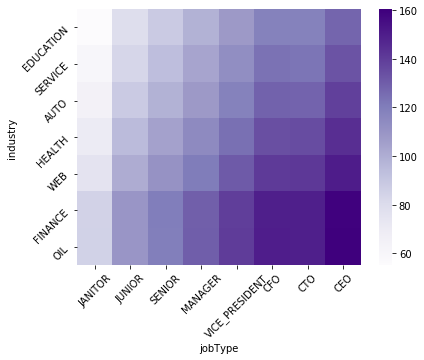

In [27]:
tup_industry = [("jobType","industry")]
heat_map((14,16),"salary",salary_new,tup_industry,"Purples")

*Job type and indsutry*

Oil and finance industries are the highest paying, even for janitorial and entry-level positions, compared to the pay in other industries.


<a id='baseline'></a>
### 5. Establish a baseline

Since there is noticeable variation in salary for different job types, we will use the average salary for each job type as the predicted salary and calculate MSE to establish our baseline. The models that we will be built need to have lower MSE than the baseline.

In [28]:
mean_job_type = salary_new.groupby("jobType").mean().reset_index()
mean_job_type.drop(columns=["yearsExperience","milesFromMetropolis"],inplace=True)

In [29]:
mean_job_type

,jobType,salary
0,JANITOR,70.813045
1,JUNIOR,95.333087
2,SENIOR,105.487775
3,MANAGER,115.368518
4,VICE_PRESIDENT,125.368630
5,CFO,135.458547
6,CTO,135.481067
7,CEO,145.311425


In [30]:
pred_bs = salary_new.join(mean_job_type.set_index(["jobType"]),on="jobType",how="left",rsuffix="predicted")

In [31]:
def mse(obs,pred):
    total = 0
    for i in range(len(obs)):
        delta = (obs[i]-pred[i])**2
        total += delta
    return total/(len(obs))   

In [32]:
mse_baseline = mse(pred_bs.salary.values,pred_bs.salarypredicted.values)

In [33]:
mse_baseline

963.9252996562875


### 6. Hypothesize solutions

Based on the EDA, features such as job type, degree, major, industry, miles from metropolis, years of experience are correlated with salary. 

Because the target variable, salary, is normally distributed and there is some correlation between features and salary, a **Linear Regression model** would be appropriate. Furthermore, a linear regression model is easily interpretable and  productionalized at low cost. We will compare the regression approach with **Random Forest** and **Gradient Boosting**, both are tree-based method robust to outliers.

In terms of feature engineering, we will convert categorical features to numeric using one-hot encoding where each category becomes a column and values are filled with 1 (if category is present) or 0 otherwise, because it retains representation of data in numeric form that machine learning models will be able to learn from. We will also drop the columns "jobID" and "companyId" as they are identifiers. 

***
## Part 3 - DEVELOP

### 7. Engineer features

**Dropping variables**

Company id and job id are identifiers that do not provide meaningful information to predict salary and will be removed.

**Converting categorical data to numerical**

One-hot encoding will be used as explained above.

In [34]:
def feature_engineer(data,dropcols,cat_var,num_var):
    featured = data.drop(columns=dropcols)
    dummy = pd.get_dummies(data[cat_var])
    num_df = data[num_var].apply(pd.to_numeric)
    new_df = pd.concat([num_df,dummy],axis=1)
    return new_df

In [35]:
dropcols = ["jobId","companyId"]
categorical_var = ["major","degree","jobType","industry"]
numerical_var = ["yearsExperience","milesFromMetropolis"]
new_salary_featured = feature_engineer(salary_new,dropcols,categorical_var,numerical_var)

In [36]:
new_salary_featured.head()

,yearsExperience,milesFromMetropolis,major_NONE,major_LITERATURE,major_BIOLOGY,major_CHEMISTRY,major_PHYSICS,major_COMPSCI,major_MATH,major_BUSINESS,...,jobType_CFO,jobType_CTO,jobType_CEO,industry_EDUCATION,industry_SERVICE,industry_AUTO,industry_HEALTH,industry_WEB,industry_FINANCE,industry_OIL
0,10,83,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
1,3,73,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,10,38,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,8,17,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,8,16,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


<a id='split'></a>

**Splitting data into training and testing sets**

In [37]:
# Create the target and feature set
target = salary_new['salary']

# Define train and test
features_train, features_test, target_train, target_test = train_test_split(new_salary_featured,target,test_size=0.20, random_state=123)

### 8. Create & test models 

<a id='lr'></a>
**Linear regression**

In [38]:
# Train model
reg  = LinearRegression().fit(features_train,target_train)

# Apply model on test set to predict salary
lr_pred = reg.predict(features_test)

In [39]:
# R^2 of model
reg.score(features_train,target_train)

0.7433458801931929

The linear regression model has an R^2 of ~0.74, which means that 74% of variation in salary can be explained by the model.

In [40]:
mse_lr = mse(list(target_test),lr_pred)
mse_lr

384.4547073148285

The model achieves MSE of ~384, which is 60% lower than the baseline.

<a id='rf'></a>
**Random forest**

After tuning parameters (number of trees, depth of trees, number of features, minimum number of samples in each leaf) by hand, the following parameters have been found to result in the lowest MSE.

Number of trees: 60

Depth of trees: 25

Maximum number of features: 30

Minimum samples in each leaf: 660


In [41]:
rf = RandomForestRegressor(n_estimators=60, n_jobs=3, max_depth=25, random_state=123, oob_score=True, max_features=30, min_samples_split=60)

In [42]:
rf.fit(features_train, target_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features=30, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=60, min_weight_fraction_leaf=0.0,
                      n_estimators=60, n_jobs=3, oob_score=True,
                      random_state=123, verbose=0, warm_start=False)

In [43]:
rf.oob_score_

0.7546201261964152

In [44]:
rf.score(features_train, target_train)

0.7844535990161307

The out of bag score is ~0.75, meaning that 75% of variation in salary can be explained by the model on unseen data that was not used in the training set. The R^2 turns out to be 0.78, meaning that 78% of variation in salary can be explained by the model on the entire training set. 

In [45]:
predictions = rf.predict(features_test)

In [46]:
mse_rf = mse(list(target_test),predictions)
mse_rf

364.9355769788953

The MSE is ~365, which is 5% lower than MSE of linear regression and 62% lower than baseline prediction where the average salary is predicted according to job type.

In [69]:
# Function to visualize feature importance
def feature_importance(data, model, n):
    df = pd.DataFrame({"Features":data.columns, "Importances":model.feature_importances_})
    df.sort_values(["Importances"], inplace=True, ascending=False)
    df.set_index("Features",inplace=True,drop=True)
    df[0:n].plot.bar(figsize=(20,10),legend=False)
    return df.sort_values(["Importances"],ascending=False)

,Importances
Features,
jobType_JANITOR,0.248402
yearsExperience,0.187005
milesFromMetropolis,0.140443
jobType_JUNIOR,0.090995
major_NONE,0.067111
jobType_SENIOR,0.059456
industry_EDUCATION,0.036522
jobType_MANAGER,0.033930
industry_SERVICE,0.026819


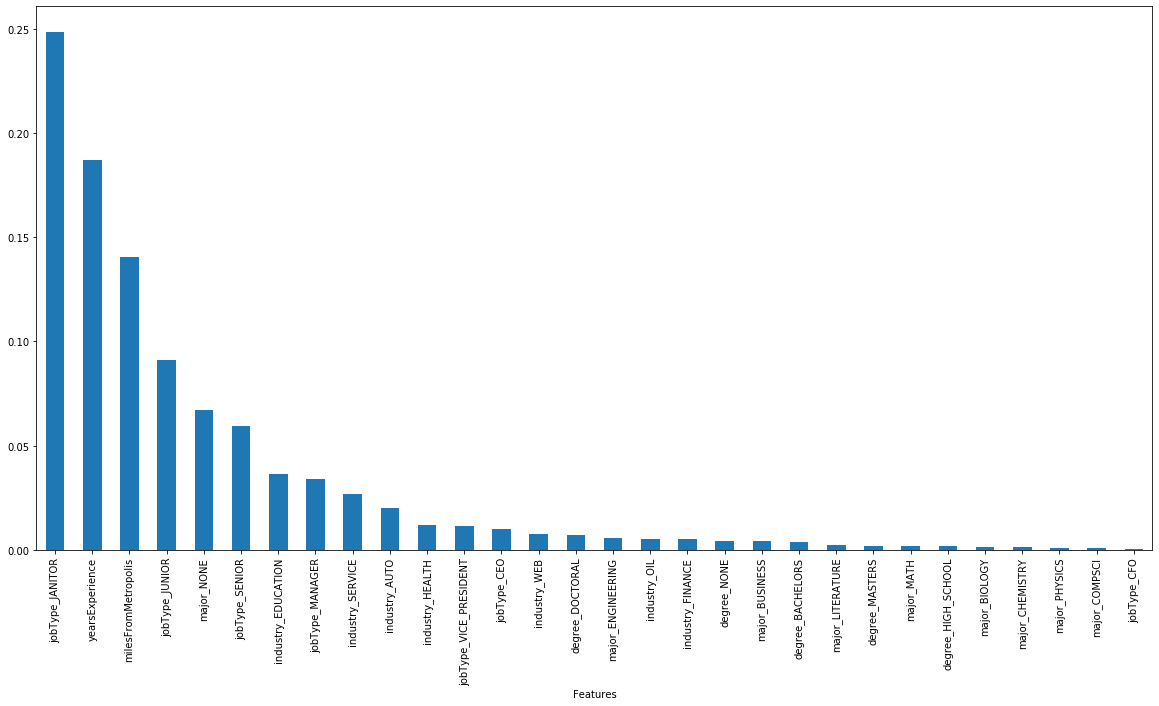

In [70]:
feature_importance(features_train, rf, 30)

Job type, years of experience, and location influence salary more than degree and major. Looking at the top 5 features for job type, junior and janitorial positions have more predictable salary compared to other positions. This is possible because entry-level and certain types of position are more likely to have a fix salary. It is intuitive that years of experience and location are strongly influence salary as people get compensated more if they have more years of experience and are closer to the city, vice-versa.

**Gradient Boosting**

The hyperparameters (number of trees and maximum depth of trees) are tuned by hand and parameters that result in the lowest MSE are selected. 

In [91]:
gb = GradientBoostingRegressor(n_estimators = 150, max_depth=5,verbose=1)
gb.fit(features_train, target_train)
gb.score(features_train, target_train)

      Iter       Train Loss   Remaining Time 
         1        1350.1331            9.73m
         2        1228.9090            9.86m
         3        1128.9600            9.85m
         4        1045.2253            9.56m
         5         974.0627            9.72m
         6         914.5097            9.87m
         7         862.0545            9.50m
         8         814.3808            9.21m
         9         772.7444            8.91m
        10         736.7700            8.71m
        20         521.6700            7.63m
        30         436.0633            7.05m
        40         397.8195            6.39m
        50         379.6589            5.80m
        60         370.0449            5.22m
        70         364.8736            4.64m
        80         361.8131            4.04m
        90         359.7044            3.45m
       100         358.1457            2.87m


0.7630059631123869

In [92]:
gb_predictions = gb.predict(features_test)

In [93]:
mse_gb = mse(list(target_test),gb_predictions)
mse_gb

355.97901559290926

The R^2 of the model is ~76%, which is higher than the linear regression and random forest models. The MSE is also lower than the previous 2 models, and lower than the baseline by ~63%.

,Importances
Features,
jobType_JANITOR,0.220535
yearsExperience,0.186632
milesFromMetropolis,0.129582
major_NONE,0.083185
jobType_JUNIOR,0.075313
jobType_CEO,0.049210
jobType_SENIOR,0.041146
industry_EDUCATION,0.030356
industry_FINANCE,0.026901


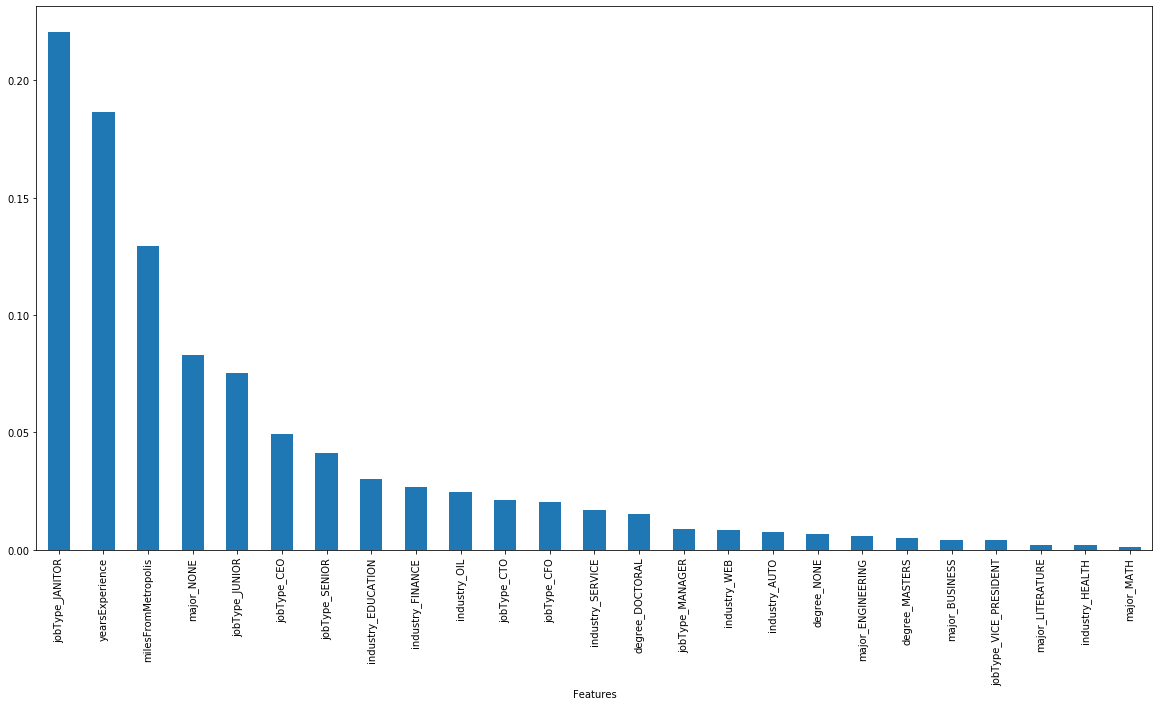

In [94]:
feature_importance(features_train, gb, 25)

The feature importance we see in the Gradient Boosting model is similar to that of the Random Forest where job type, years of experience, and location strongly influence salary.

<a id='best'></a>
### 9. Select best model 

Since our goal is to select the model that achieves the lowest MSE, we will select the **Gradient Boosting** model.

***
## Part 4 - DEPLOY

<a id='automate'></a>
### 10. Automate pipeline

We will train the Gradient Boosting model on the entire data set we have and apply it on the unseen data set to predict salary.

We will also perform the same feature engineering on our unseen data as we did for our original data set.

In [95]:
gb.fit(new_salary_featured,target)

      Iter       Train Loss   Remaining Time 
         1        1351.2830           12.30m
         2        1229.8976           12.01m
         3        1129.7084           12.18m
         4        1045.3752           12.18m
         5         974.4283           11.94m
         6         914.9446           12.04m
         7         862.6779           11.92m
         8         814.8460           11.69m
         9         772.9795           11.46m
        10         737.2014           11.28m
        20         519.7989           10.05m
        30         434.7553            9.37m
        40         397.1956            8.68m
        50         379.5828            8.63m
        60         370.1793            7.99m
        70         365.1219            7.21m
        80         361.8448            6.33m
        90         359.7451            5.31m
       100         358.2108            4.33m


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=1, warm_start=False)

In [96]:
# Loading unseen data set
test_salary_features = pd.read_csv("./data/test_features.csv")

In [97]:
# Engineer features on unseen data set
test_engineered = feature_engineer(test_salary_features,dropcols,categorical_var,numerical_var)
# Apply model on engineered features
predictions = gb.predict(test_engineered)

In [105]:
predicted = pd.DataFrame({"jobId":test_salary_features["jobId"],"predicted_salary":predictions})

We will save the salary predictions of job descriptions in a csv file so that finance team can analyze and allocate budget for new hires. The model and feature importances will also be saved so that it can be readily applied on new data.

In [102]:
# Function to save model
def save_results(model, predictions):
    '''saves model, model summary, feature importances, and predictions'''
    with open('./model/model.txt', 'w') as file:
        file.write(str(model))
    feature_importances = feature_importance(new_salary_featured,model,25)
    feature_importances.to_csv("./model/feature_importance.csv")
    predictions.to_csv("./data/predictions.csv",index=False)
    return(feature_importances)

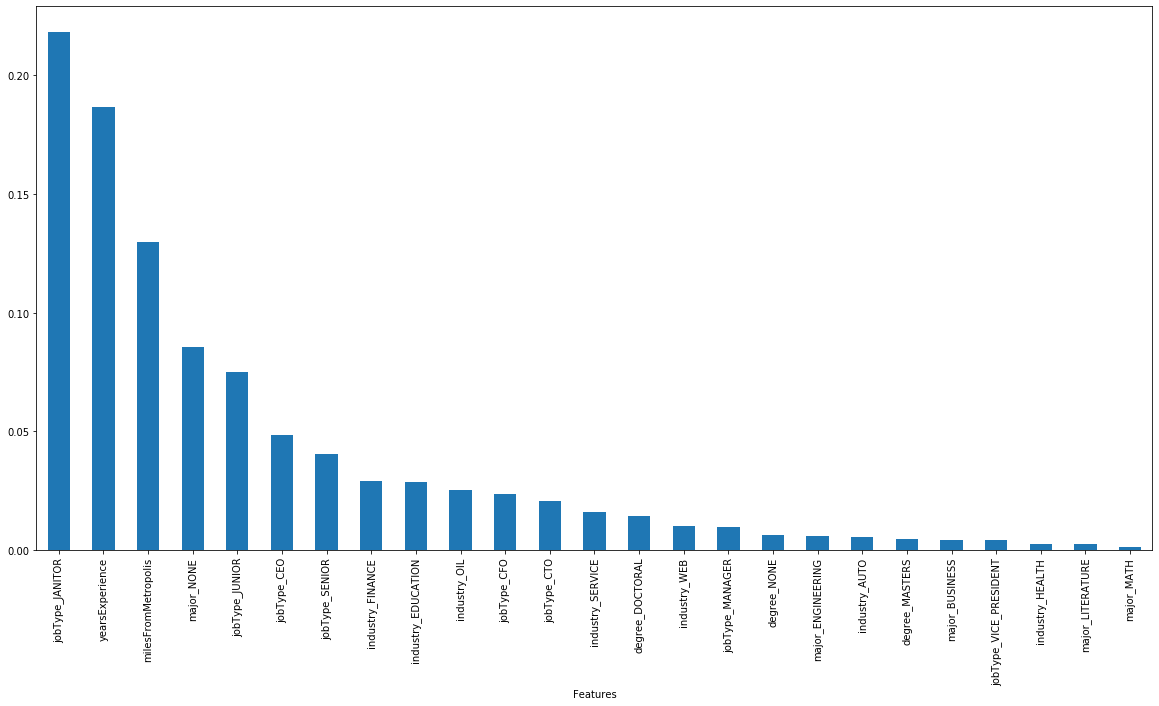

In [107]:
feature = save_results(gb,predicted)

Again, similar pattern of feature importance is seen.

***
<a id='rec'></a>
## Part 5 - Actionable recommendations

Since job position, years of experience, and location strongly influence salary, a company's finance team might want to consider these factors when allocating budget for new hires. On the other hand, if a company has fixed budget on new hires, they can decide what kind of position to hire for based on how much they have. For instance, if a company has $200k budget, then it can afford to hire a managerial position, instead of a VP.

Salary varies according to the following

- Job position: CEO > CTO & CFO > VP > Manager > Senior > Junior > Janitor
- Salary increases linearly with years of experience
- Salary decreases linearly with miles away from city
- Oil and finance industries are the highest paying, auto, health, and web are average paying, while service and education are the lowest paying.

Based on this information, candidates can also decide the type of industry, location, and position to target to achieve the desired salary.

**Caveat**

The type of company and economy are important factors to consider when predicting salary but they are not included in the model. A start-up will pay less than a bigger company and salary will be lower during times of economic downturn. While it is important to consider the type of position and industry, we should also keep in mind other variables that are not included in the model.